In [1]:
import cv2
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import glob
import pandas as pd
import json
from scipy.optimize import least_squares
import math
import random
from misc.utils import *
from misc.FundamentalMatrix import *

from misc.PoseEstimation import recoverPose
from misc.printFunctions import *
from misc.DisparityMap import *


## Get matching Sift points Get fundamental matrix and Inliers

In [65]:
"""
https://github.com/eddiecorrigall/Vision/blob/master/Stereo/rectify.py
"""

"""
https://www.andreasjakl.com/understand-and-apply-stereo-rectification-for-depth-maps-part-2/
"""
Fmats = []
for i in  range(1,4):
    images, K1, K2, params = readData(i)
    im1, im2 = images
    im1, im2 = rescale(im1,30), rescale(im2,30)
    h1, w1 = im1.shape[:2]
    h2, w2 = im2.shape[:2]
    pts1, pts2, im_matches = SIFTpoints(im1, im2)
    #     print(len(pts1))
    # F,inlier_mask  = cv2_FundamentalMatrix(pts1,pts2, a = 1, b= 0.90)

    data = (pts1,pts2)

    F,inlier_mask = FundamentalMatrix(data ,s = 8, thresh = 0.001,n_iterations = 2000)
    pts1_ = pts1[inlier_mask==1]
    pts2_ = pts2[inlier_mask==1]


    # print('F matrix ', i, '\n' )
    # print(F)
    # print('\n')


    E = EssentialMatrix(K1,K2, F)
    # print('E matrix ', i, '\n' )
    # print(E)
    # print('\n')

    R, C, x3D = recoverPose(E, pts1_, pts2_, K1, K2)

    # print('Rotation matrix ', i, '\n' )
    # print(R, '\n')
    # print('Translation matrix ', i, '\n' )
    # print(C, '\n')
    # print('\n')

    ret,H1, H2 = cv2.stereoRectifyUncalibrated(np.float32(pts1_), np.float32(pts2_), F, imgSize=(w1, h1))

    print('Homography matrix left image ', i, '\n' )
    print(H1, '\n')
    print('Homography matrix right image ', i, '\n' )
    print(H2, '\n')
    print('\n')


Homography matrix left image  1 

[[ 3.51271192e-03  8.58694699e-05 -1.58860761e-01]
 [-1.40369274e-05  3.44664070e-03  7.15015762e-03]
 [ 6.46763850e-08 -7.90030911e-09  3.42176203e-03]] 

Homography matrix right image  1 

[[ 1.00768282e+00  9.70519530e-03 -6.36316563e+00]
 [-4.43770207e-03  1.00000364e+00  1.98699533e+00]
 [ 1.72526638e-05  1.66163865e-07  9.92220791e-01]] 



Homography matrix left image  2 

[[ 2.96671669e-03 -3.04047918e-04 -9.70816157e-02]
 [-3.77098264e-05  2.89204345e-03  1.66634082e-02]
 [-8.91562817e-08  9.99970064e-09  2.92677076e-03]] 

Homography matrix right image  2 

[[ 9.88113446e-01  3.71246032e-03  4.03239073e+00]
 [-1.19242468e-02  9.99962257e-01  5.16248423e+00]
 [-2.74988342e-05 -1.03316407e-07  1.01191018e+00]] 



Homography matrix left image  3 

[[-2.69515462e-03 -7.16375650e-05 -2.42354595e-03]
 [ 1.70313689e-04 -2.99162779e-03 -8.42710368e-02]
 [ 5.32322966e-07  2.54810876e-08 -3.26221264e-03]] 

Homography matrix right image  3 

[[ 9.2134

In [10]:
im1_rectified = cv2.warpPerspective(im1, H1, (w1, h1))
im2_rectified = cv2.warpPerspective(im2, H2, (w2, h2))

F matrix  3 

[[ 9.21065777e-11  1.56981410e-07 -1.79940246e-06]
 [-1.47923065e-07 -1.60055293e-08  2.86949366e-03]
 [ 7.11438678e-10 -2.86057740e-03  2.17054582e-04]]


E matrix  3 

[[-0.00146529  0.32736451  0.0605365 ]
 [-0.30781796 -0.01707708  0.94967063]
 [-0.04785138 -0.94328238 -0.01328264]]


Rotation matrix  3 

[[ 0.99973415  0.00844246 -0.02145581]
 [-0.00811401  0.99984927  0.0153494 ]
 [ 0.02158216 -0.01517123  0.99965196]] 

Translation matrix  3 

[ 0.94295581 -0.05551728  0.32825625] 





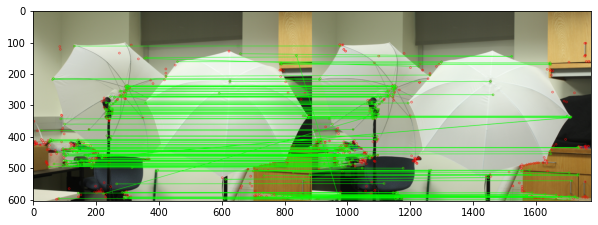

In [11]:
plt.figure(figsize = (10,10))
plt.imshow(im_matches)
plt.savefig('matches1')

# Compute the epipolar lines and plot few

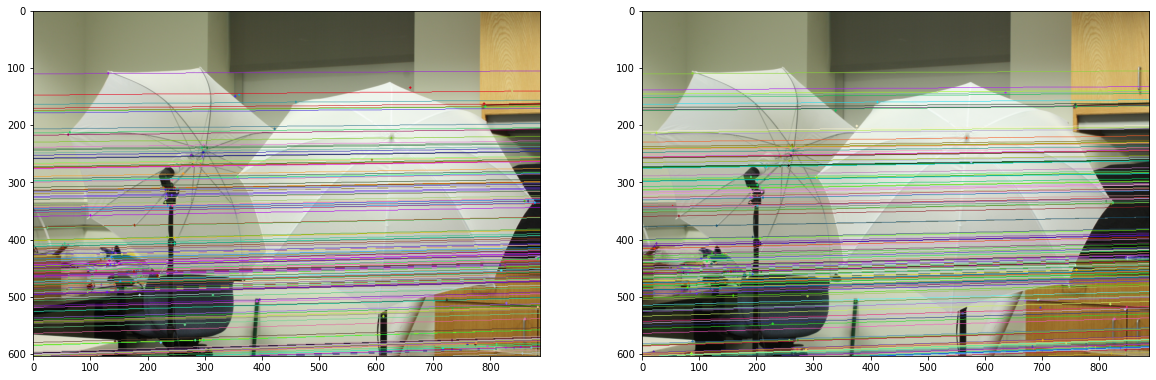

In [12]:
# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
l1 = cv2.computeCorrespondEpilines(pts2_.reshape(-1,1,2), 2,F)
img5,_ = drawEpilines(im1,im2,l1,pts1_,pts2_)

# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
l2 = cv2.computeCorrespondEpilines(pts1_.reshape(-1,1,2), 1,F)
img3,_ = drawEpilines(im2,im1,l2,pts2_,pts1_)
plt.figure(figsize = (20,20))
plt.subplot(121),plt.imshow(img5)
plt.subplot(122),plt.imshow(img3)
plt.show()

# Obtain the Homographies

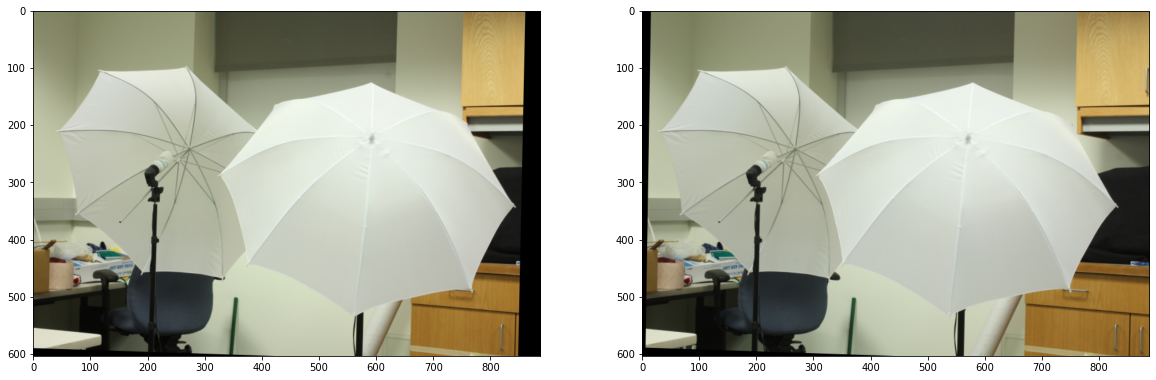

In [13]:
ret,H1, H2 = cv2.stereoRectifyUncalibrated(np.float32(pts1_), np.float32(pts2_), F, imgSize=(w1, h1))

im1_rectified = cv2.warpPerspective(im1, H1, (w1, h1))
im2_rectified = cv2.warpPerspective(im2, H2, (w2, h2))
ax, plts = plt.subplots(1,2, figsize = (20,20))
plts[0].imshow(im1_rectified)
plts[1].imshow(im2_rectified)

# find the rectified sift points

In [7]:
dst1 = cv2.perspectiveTransform(pts1_.reshape(-1,1,2), H1).squeeze()
dst2 = cv2.perspectiveTransform(pts2_.reshape(-1,1,2),H2).squeeze()

lines1_ = epiLines(pts2_,2, F, w2)
warpedlines1 = warpEpilines(lines1_, H1)

lines2_ = epiLines(pts1_,1, F, w2)
warpedlines2 = warpEpilines(lines2_, H2)

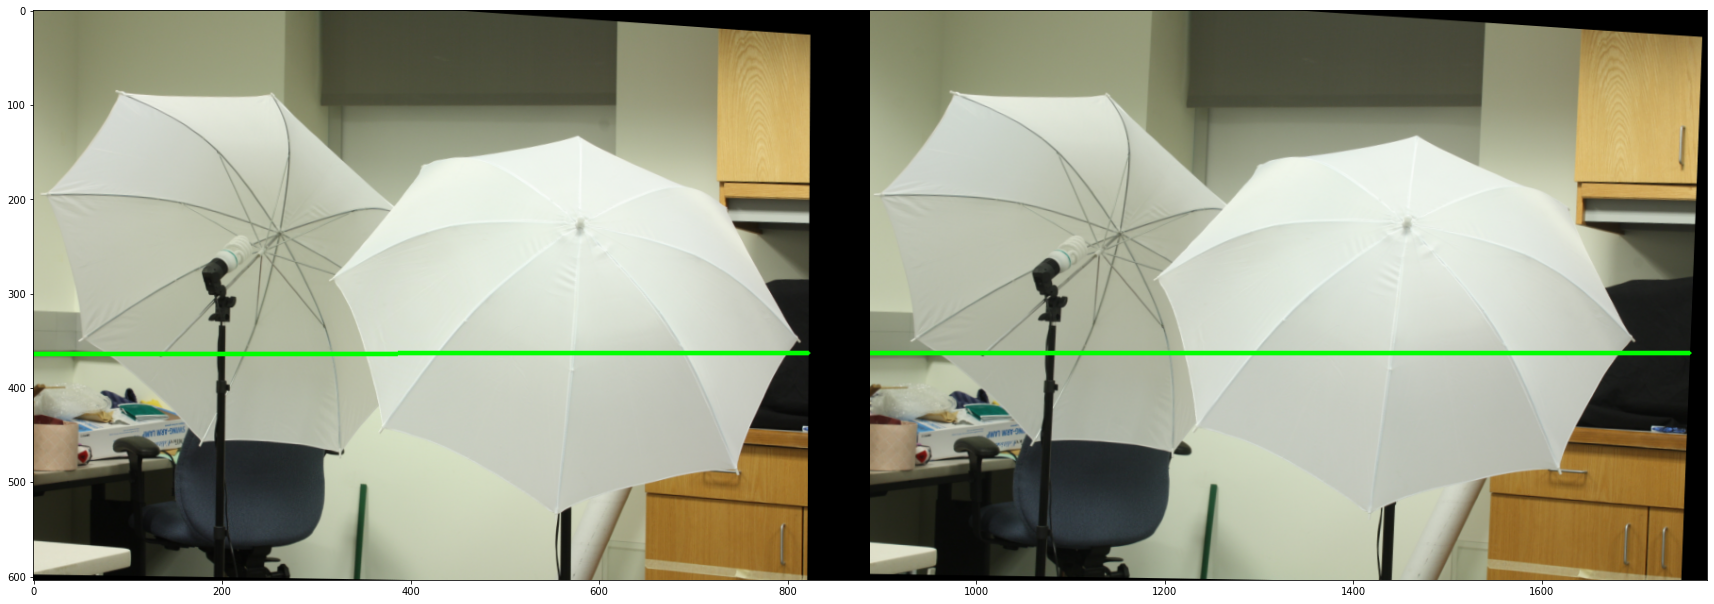

In [8]:
im1_print = drawLines(im1_rectified, warpedlines1[:1], dst1[:1])
im2_print = drawLines(im2_rectified, warpedlines2[:1], dst2[:1])

# ax, plts = plt.subplots(1,2, figsize = (20,20))
# plts[0].imshow(im1_print)
# plts[1].imshow(im2_print)

out = np.hstack((im1_print, im2_print))
plt.figure(figsize = (30,30))
plt.imshow(out)

In [12]:
imL = gray(im1_rectified)
imR = gray(im2_rectified)
disparityMap = DisparityMap(imL, imR, warpedlines1, warpedlines2, win_size = 11, searchRange = 110 )
disparity_map_print = cv2.normalize(disparityMap, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F).astype(np.uint8)

100%|██████████| 572/572 [19:08<00:00,  2.01s/it]   


In [15]:
heatmap = cv2.applyColorMap(disparity_map_print, cv2.COLORMAP_HOT)

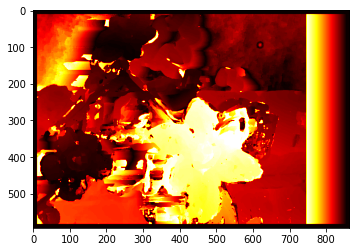

In [14]:
plt.imshow(disparityMap, 'hot')

In [39]:
np.save('dispMap2.npy', disparityMap)

In [17]:
cv2.imwrite('heatmap_dataset2.png', heatmap)

True

In [15]:
disparityMap1 = np.load('./Output/Dataset1/disparityMap.npy')
disparityMap2 = np.load('./Output/Dataset2/disparityMap.npy')
disparityMap3 = np.load('./Output/Dataset3/disparityMap.npy')


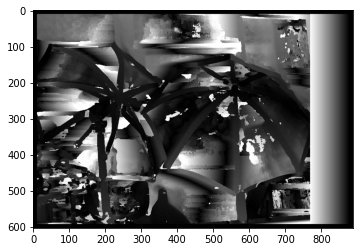

In [23]:
plt.imshow(disparityMap3, 'gray')
plt.savefig('./Output/Dataset3/disparityMap_gray.png')

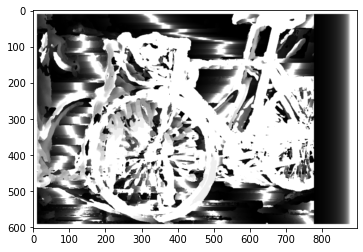

In [62]:
# doffs, baseline,width, height, ndisp, isint, vmin, vmax,dyavg, dymax
images, K1, K2, params = readData(1)

baseline = params[1]
f = K1[0,0]

depthMap = (baseline*f)/(disparityMap1 + 1e-15)
depthMap[depthMap > 100000] = 100000
depthMap = np.uint8(depthMap * 255 / np.max(depthMap))
plt.imshow(depthMap, cmap='gray', interpolation='bilinear')
plt.savefig('./Output/Dataset1/depthMap_gray.png')

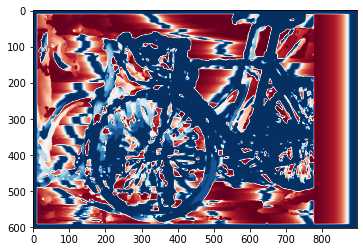

In [63]:
plt.imshow(depthMap, cmap=plt.cm.RdBu, interpolation='bilinear')
plt.savefig('./Output/Dataset1/depthMap.png')

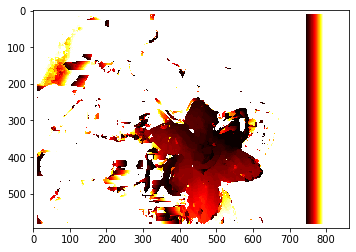

In [15]:
dispVals = list(np.unique(disparityMap))

In [33]:
depthmap = baseline*f/disparityMap

/home/gokul/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


In [34]:
depthmap

array([[inf, inf, inf, ..., inf, inf, inf],
       [inf, inf, inf, ..., inf, inf, inf],
       [inf, inf, inf, ..., inf, inf, inf],
       ...,
       [inf, inf, inf, ..., inf, inf, inf],
       [inf, inf, inf, ..., inf, inf, inf],
       [inf, inf, inf, ..., inf, inf, inf]])

In [36]:
np.unique(depthmap)

array([  5757.85984165,   5810.68424386,   5864.48687575,   5919.29516431,
         5975.13757152,   6032.04364363,   6090.04406328,   6149.17070467,
         6209.45669197,   6270.9364612 ,   6333.64582581,   6397.62204627,
         6462.90390389,   6529.53177919,   6597.54773522,   6666.99560612,
         6737.92109129,   6810.37185571,   6884.39763675,   6960.05035803,
         7037.3842509 ,   7116.45598406,   7197.32480206,   7280.05267334,
         7364.70444862,   7451.34803036,   7540.05455454,   7630.89858531,
         7723.95832416,   7819.31583433,   7917.05728226,   8017.27319723,
         8120.05875104,   8225.51405949,   8333.74450764,   8444.86110108,
         8558.98084569,   8676.22715864,   8796.73031362,   8920.62792368,
         9048.06546544,   9179.196849  ,   9314.18503796,   9453.20272509,
         9596.43306941,   9744.07050125,   9896.32160283,  10053.40607271,
        10215.55778356,  10383.02594395,  10556.07637635,  10734.9929251 ,
        10920.07901002,  

In [35]:
maxDepth = np.unique(depthmap).max()

dispVals.remove(min(dispVals))

inf

In [27]:
maxDepth = np.unique(depthmap).max()
minDepth = np.unique(depthmap).min()

depthmap = np.clip(depthmap, minDepth, maxDepth*0.99)
depthmap

array([[6.27030937e+15, 6.27030937e+15, 6.27030937e+15, ...,
        6.27030937e+15, 6.27030937e+15, 6.27030937e+15],
       [6.27030937e+15, 6.27030937e+15, 6.27030937e+15, ...,
        6.27030937e+15, 6.27030937e+15, 6.27030937e+15],
       [6.27030937e+15, 6.27030937e+15, 6.27030937e+15, ...,
        6.27030937e+15, 6.27030937e+15, 6.27030937e+15],
       ...,
       [6.27030937e+15, 6.27030937e+15, 6.27030937e+15, ...,
        6.27030937e+15, 6.27030937e+15, 6.27030937e+15],
       [6.27030937e+15, 6.27030937e+15, 6.27030937e+15, ...,
        6.27030937e+15, 6.27030937e+15, 6.27030937e+15],
       [6.27030937e+15, 6.27030937e+15, 6.27030937e+15, ...,
        6.27030937e+15, 6.27030937e+15, 6.27030937e+15]])

In [28]:
depthmap

array([[6.27030937e+15, 6.27030937e+15, 6.27030937e+15, ...,
        6.27030937e+15, 6.27030937e+15, 6.27030937e+15],
       [6.27030937e+15, 6.27030937e+15, 6.27030937e+15, ...,
        6.27030937e+15, 6.27030937e+15, 6.27030937e+15],
       [6.27030937e+15, 6.27030937e+15, 6.27030937e+15, ...,
        6.27030937e+15, 6.27030937e+15, 6.27030937e+15],
       ...,
       [6.27030937e+15, 6.27030937e+15, 6.27030937e+15, ...,
        6.27030937e+15, 6.27030937e+15, 6.27030937e+15],
       [6.27030937e+15, 6.27030937e+15, 6.27030937e+15, ...,
        6.27030937e+15, 6.27030937e+15, 6.27030937e+15],
       [6.27030937e+15, 6.27030937e+15, 6.27030937e+15, ...,
        6.27030937e+15, 6.27030937e+15, 6.27030937e+15]])

In [23]:
dispVals = list(np.unique(disparityMap))

dispVals.remove(min(dispVals))
minDisparity = min(dispVals)
maxDisparity = max(dispVals)

In [24]:
maxDepth = baseline*f/minDisparity
minDepth = baseline*f/disparityMap.max()

depthmap = baseline*f/(disparityMap)

/home/gokul/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


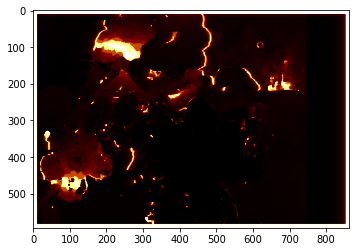

In [25]:
depthmap = np.clip(depthmap, minDepth, maxDepth*1.25)

depthmap_print = cv2.normalize(depthmap, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F).astype(np.uint8)
plt.imshow(depthmap_print, 'afmhot')

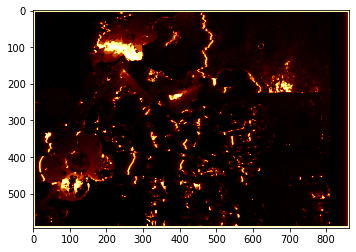